In [34]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Define the U-Net architecture for binary segmentation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (downsampling path)
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder (upsampling path)
        self.dec_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv1 = nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv3 = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1)
        self.dec_conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.dec_upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv5 = nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1)
        self.dec_conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.dec_upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv7 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1)
        self.dec_conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

          # Output
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)  # 1x1 convolution for binary segmentation


    def forward(self, x):
        # Encoder (downsampling path)
        enc1 = nn.ReLU()(self.enc_conv1(x))
        enc2 = nn.ReLU()(self.enc_conv2(enc1))
        enc2_pool = self.enc_pool1(enc2)

        enc3 = nn.ReLU()(self.enc_conv3(enc2_pool))
        enc4 = nn.ReLU()(self.enc_conv4(enc3))
        enc4_pool = self.enc_pool2(enc4)

        enc5 = nn.ReLU()(self.enc_conv5(enc4_pool))
        enc6 = nn.ReLU()(self.enc_conv6(enc5))
        enc6_pool = self.enc_pool3(enc6)

        enc7 = nn.ReLU()(self.enc_conv7(enc6_pool))
        enc8 = nn.ReLU()(self.enc_conv8(enc7))
        enc8_pool = self.enc_pool4(enc8)

        # Bottleneck
        bottleneck = nn.ReLU()(self.bottleneck_conv1(enc8_pool))
        bottleneck = nn.ReLU()(self.bottleneck_conv2(bottleneck))

        # Decoder (upsampling path)
        dec1 = self.dec_upsample1(bottleneck)
        dec1 = torch.cat([dec1, enc8], dim=1)
        dec1 = nn.ReLU()(self.dec_conv1(dec1))
        dec1 = nn.ReLU()(self.dec_conv2(dec1))

        dec2 = self.dec_upsample2(dec1)
        dec2 = torch.cat([dec2, enc6], dim=1)
        dec2 = nn.ReLU()(self.dec_conv3(dec2))
        dec2 = nn.ReLU()(self.dec_conv4(dec2))

        dec3 = self.dec_upsample3(dec2)
        dec3 = torch.cat([dec3, enc4], dim=1)
        dec3 = nn.ReLU()(self.dec_conv5(dec3))
        dec3 = nn.ReLU()(self.dec_conv6(dec3))

        dec4 = self.dec_upsample4(dec3)
        dec4 = torch.cat([dec4, enc2], dim=1)
        dec4 = nn.ReLU()(self.dec_conv7(dec4))
        dec4 = nn.ReLU()(self.dec_conv8(dec4))

        # Output
        output = self.output_conv(dec4)
        return output   
    
    # Create an instance of the FCN model
model = UNet()

# Example usage:
input_tensor = torch.randn(1, 3, 256, 256)  # Example input tensor with shape (batch_size, channels, height, width)
output_tensor = model(input_tensor)  # Forward pass through the FCN model

print(output_tensor.shape)  # Shape of the output tensor

torch.Size([1, 1, 256, 256])


In [36]:
# Define criterion and optimizer
criterion = nn.MSELoss()  # nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to a specific size
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Example normalization values for RGB images
    #                         std=[0.229, 0.224, 0.225])
])

# transform_mask = transforms.Compose([
#     transforms.Resize((256, 256)),  # Resize the image to a specific size
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Example normalization values for RGB images
#     #                         std=[0.229, 0.224, 0.225])
# ])

In [39]:
import numpy
# In this example, the CustomDataset takes in two lists of file paths: image_list and mask_list, representing the paths to the images and their corresponding masks, 
# respectively. It also takes in an optional transform argument to apply any necessary transformations to the images and masks.
class CustomDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        # self.image_list = image_list
        # self.mask_list = mask_list
        self.image_list = [os.path.join(image_list, f) for f in os.listdir(image_list)]
        self.mask_list = [os.path.join(mask_list, f) for f in os.listdir(mask_list)]
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')
        mask = Image.open(mask_path)
        mask = mask.convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)


        return image, mask
    
    # Open the binary image
import numpy

# image_path = "Droplet_Mask_XY_val/drop_s40_v5_r0.5_str5_pos0_cam1_camx0.png"
# image = Image.open(image_path)  # Replace "binary_image.png" with the path to your binary image

# # Resize the image to the desired dimensions (e.g., 256x256)
# desired_size = (256, 256)
# resized_image = image.resize(desired_size)

# # Convert the resized image to grayscale (if needed)
# resized_image = resized_image.convert("L")

# # Convert the resized image to a binary numpy array
# # binary_array = resized_image.point(lambda x: 0 if x < 128 else 1, mode="1").getdata()
# binary_array = numpy.array(resized_image).reshape(resized_image.size[::-1])

# # Convert the binary numpy array to a tensor
# binary_tensor = torch.from_numpy(binary_array).unsqueeze(0).unsqueeze(0).float()


# # Print the size and values of the binary tensor
# print("Size:", binary_tensor.size())
# print("Values:", binary_tensor)

In [43]:
# Load the data
train_data = CustomDataset('Droplet_XY/','Droplet_Mask_XY/', transform=transform)
val_data = CustomDataset('Droplet_XY_val/','Droplet_Mask_XY_val/', transform=transform)

In [44]:
# Define the data loader
batch_size = 3
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [45]:
num_epochs = 5

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    # Iterate over the training data
    for i, (images, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss every 10 batches
        if i % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Set the model to evaluation mode
    model.eval()
    
    # Compute the validation loss
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Accumulate the loss over all batches
            val_loss += loss.item() * images.size(0)
    
    # Compute the average validation loss
    val_loss /= len(val_data)
    print(f'Epoch [{epoch+1}/{num_epochs}] , Val Loss: {val_loss:.4f}')

Epoch [1/5], Batch [1/23], Loss: 0.8930
Epoch [1/5], Batch [2/23], Loss: 0.1563
Epoch [1/5], Batch [3/23], Loss: 0.3843
Epoch [1/5], Batch [4/23], Loss: 0.2124
Epoch [1/5], Batch [5/23], Loss: 0.0865
Epoch [1/5], Batch [6/23], Loss: 0.0369
Epoch [1/5], Batch [7/23], Loss: 1.2345
Epoch [1/5], Batch [8/23], Loss: 0.0218
Epoch [1/5], Batch [9/23], Loss: 0.0242
Epoch [1/5], Batch [10/23], Loss: 0.0208
Epoch [1/5], Batch [11/23], Loss: 0.0195
Epoch [1/5], Batch [12/23], Loss: 0.0199
Epoch [1/5], Batch [13/23], Loss: 0.0198
Epoch [1/5], Batch [14/23], Loss: 0.0196
Epoch [1/5], Batch [15/23], Loss: 0.0195
Epoch [1/5], Batch [16/23], Loss: 0.0196
Epoch [1/5], Batch [17/23], Loss: 0.0197
Epoch [1/5], Batch [18/23], Loss: 0.0197
Epoch [1/5], Batch [19/23], Loss: 0.0196
Epoch [1/5], Batch [20/23], Loss: 0.0195
Epoch [1/5], Batch [21/23], Loss: 0.0196
Epoch [1/5], Batch [22/23], Loss: 0.0196
Epoch [1/5], Batch [23/23], Loss: 0.0198
Epoch [1/5] , Val Loss: 0.0199
Epoch [2/5], Batch [1/23], Loss: 0.

In [76]:
# Testing model on given outptu
# image_path = "Droplet_XY_val/drop_s40_v5_r0.5_str2_pos2.png"drop_s40_v5_r0.5_str5_pos11.png
image_path = "Droplet_XY_val/drop_s40_v5_r0.5_str2_pos6.png"
image = Image.open(image_path)
image = image.convert('RGB')
img = transform(image)
img = img.unsqueeze(0)
img.size()
# image.show()
# model(img)

torch.Size([1, 3, 256, 256])

In [13]:
# Plot that bitch


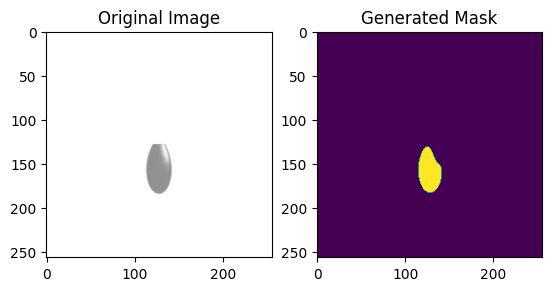

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the trained model and a test image

# Set the model to evaluation mode
model.eval()

# Perform forward pass on the test image
with torch.no_grad():
    output = model(img)  # Assuming you have the test image as a tensor

# Convert the output tensor to a numpy array and squeeze the batch and channel dimensions
output_np = output.squeeze(0).squeeze(0).cpu().numpy()

# Apply a threshold to convert the output to a binary mask
threshold = 0.5  # Adjust the threshold value as needed
mask = (output_np >= threshold).astype(np.uint8)
# Plot the original test image
plt.subplot(1, 2, 1)
plt.imshow(image.resize((256,256)))
plt.title('Original Image')

# Plot the generated mask
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Generated Mask')

plt.show()